In [1]:
import andes
import numpy as np
from andes.interop.pandapower import to_pandapower, make_link_table, runopp_map
from andes.interop.pandapower import add_gencost, build_group_table
andes.config_logger(stream_level=20)

from math import ceil, floor

import os

Find the approriate load scaling factor

In [2]:
dir_path = os.path.abspath('..')
case_path = '/case/ieee39_ev.xlsx'
case = dir_path + case_path
ssa = andes.load(case,
                 setup=True,
                 no_output=True,
                 default_config=False)

Working directory: "/Users/jinningwang/Documents/work/andes/jwang/notes"
> Loaded config from file "/Users/jinningwang/.andes/andes.rc"
> Loaded generated Python code in "/Users/jinningwang/.andes/pycode".
Parsing input file "/Users/jinningwang/Documents/work/andes/jwang/case/ieee39_ev.xlsx"...
Input file parsed in 0.5968 seconds.
ACEc <1> added BusFreq <BusFreq_11> linked to bus <1>
System internal structure set up in 0.0561 seconds.


In [3]:
# --- Generation ---
stg_idx = ssa.PV.idx.v + ssa.Slack.idx.v
stg_p0 = ssa.StaticGen.get(src='p0', idx=stg_idx, attr='v')
print('StatigGen.p0.sum()=',stg_p0.sum())

# --- Load ---
pq_p0 = ssa.PQ.get(src='p0', idx=ssa.PQ.idx.v, attr='v')
pq_q0 = ssa.PQ.get(src='q0', idx=ssa.PQ.idx.v, attr='v')
print('PQ.p0.sum()=',pq_p0.sum())
print('PQ.q0.sum()=',pq_q0.sum())

StatigGen.p0.sum()= 58.932563789999996
PQ.p0.sum()= 58.564
PQ.q0.sum()= 17.345


ieee39_b:

k: [1, 1.4], ok

ieee39_ev:

k: [1, 1.4], ok

In [4]:
# --- load scale ---
k=1
ssa.PQ.set(src='p0', idx=ssa.PQ.idx.v, attr='v',
            value=pq_p0 * k)
ssa.PQ.set(src='q0', idx=ssa.PQ.idx.v, attr='v',
           value=pq_q0 * k)

pq_p = ssa.PQ.get(src='p0', idx=ssa.PQ.idx.v, attr='v')
pq_q = ssa.PQ.get(src='q0', idx=ssa.PQ.idx.v, attr='v')
print('PQ.p0.sum()=',pq_p.sum())
print('PQ.q0.sum()=',pq_q.sum())

PQ.p0.sum()= 58.564
PQ.q0.sum()= 17.345


In [5]:
ssa.PFlow.run()
ssa.TDS.run()

-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.5194 seconds.
0: |F(x)| = 7.561234472
1: |F(x)| = 2.916785547
2: |F(x)| = 0.1314169329
3: |F(x)| = 0.0003491192411
4: |F(x)| = 4.2404249e-09
Converged in 5 iterations in 0.0079 seconds.

-> Time Domain Simulation Summary:
Sparse Solver: KLU
Simulation time: 0.0-20.0 s.
Fixed step size: h=33.33 ms. Shrink if not converged.
Numba compilation initiated with caching.
GENROU (xl <= xd2) out of typical upper limit.

   idx     | values | limit
-----------+--------+------
 GENROU_1  | 0.012  | 0.001
 GENROU_2  | 0.042  | 0.036
 GENROU_3  | 0.036  | 0.003
 GENROU_4  | 0.025  | 0.001
 GENROU_5  | 0.050  | 0.001
 GENROU_7  | 0.031  | 0.002
 GENROU_8  | 0.029  | 0.006
 GENROU_9  

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.7973 seconds.


True

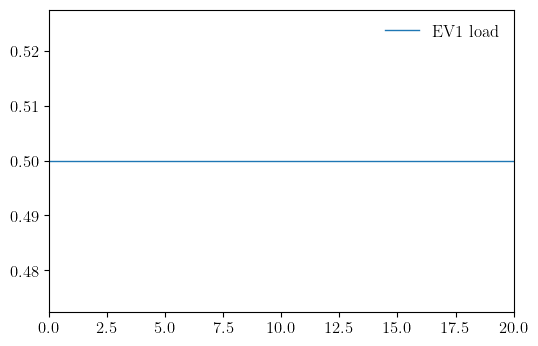

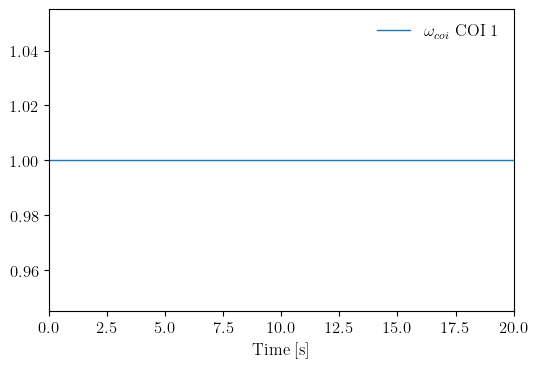

(<Figure size 600x400 with 1 Axes>, <AxesSubplot:xlabel='Time [s]'>)

In [6]:
Ipout = -1 * ssa.dae.ts.x[:, ssa.EV2.Ipout_y.a]
v = ssa.dae.ts.y[:, ssa.EV2.v.a]
p_ev = Ipout * v
ssa.TDS.plt.plot_data(ssa.dae.ts.t, p_ev,
                      yheader=['EV1 load'], ylable='p.u.')
ssa.TDS.plt.plot(ssa.COI.omega)